In [1]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchaudio
import sys
import librosa
from librosa import display, feature
import numpy as np
sys.path.append("..") # Adds higher directory to python modules path.

from asr.data import TextTransform, get_audio_transforms, data_processing
from asr.models import SpeechRecognitionModel
from asr.train import train
from asr.test import test
from asr.utils import IterMeter
from logger.train_logger import TrainLogger
from args.asr_train_arg_parser import ASRTrainArgParser
from saver.model_saver import ModelSaver
from dataset.dataset import Dataset
from cycleGAN.utils import get_audio_transforms, data_processing

/opt/conda/envs/asr/lib/python3.9/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
class Arguments():
    data_dir = '/home/data/'
    coraal = True
    voc = True
    return_pair = True
    source_id = "28"
    target_id = "DCB_se2_ag3_m_02_1"
    manifest_path = "../manifests/"
args = Arguments()

In [3]:
train_dataset = Dataset(args, "train", coraal=args.coraal, voc=args.voc, return_pair=args.return_pair)

In [4]:
import IPython.display as ipd

In [5]:
x, y = train_dataset[0]

In [6]:
ipd.Audio(x[0], rate=x[1])

In [24]:
(waveform_A, sample_rate_A, _, _, _) = x
audio_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate_A, n_mels=36, hop_length=2048//4,n_fft=2048)
# audio_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate_A, n_mels=36,n_fft=2048)
# audio_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate_A, n_mels=128)
spec_A = audio_transform(waveform_A).squeeze(0)
print(f'spec_A shape is {spec_A.shape}')

spec_A shape is torch.Size([36, 917])


torch.Size([36, 917])

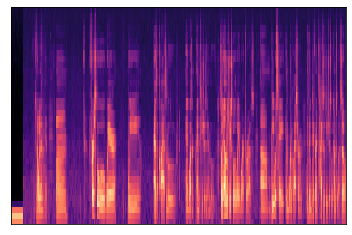

In [25]:
librosa.display.specshow(librosa.power_to_db(spec_A.numpy(), ref=np.max))
spec_A.shape

In [81]:
waveform_A

tensor([[1.9531e-03, 1.9836e-03, 1.8311e-03,  ..., 3.0518e-05, 0.0000e+00,
         0.0000e+00]])

(128, 1833)

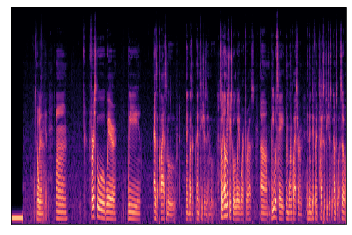

In [12]:
S = librosa.feature.melspectrogram(y=waveform_A.numpy().squeeze(), n_mels=128, sr=sample_rate_A)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
S.shape

In [8]:
# count = 1
# for i, (input_A, input_B) in enumerate(train_dataset):
#     if i == count:
#         break
#     (waveform_A, sample_rate_A, _, _, _) = input_A
#     (waveform_B, sample_rate_B, _, _, _) = input_B

In [9]:
# ipd.Audio(waveform_A, rate=sample_rate_A)

In [10]:
# ipd.Audio(waveform_B, rate=sample_rate_B)

In [11]:
# count = 1
# for i, x in enumerate(train_dataset):
#     if i == count:
#         break
#     (waveform, sample_rate, ground_truth_text, speaker_ids, duration) = x
    
#     print(ground_truth_text)
#     ipd.Audio(waveform, rate=sample_rate)

In [12]:
# (waveform, sample_rate, ground_truth_text, speaker_ids, duration) = train_dataset[500]
# print(ground_truth_text)
# ipd.Audio(waveform, rate=sample_rate)

In [84]:
import pandas as pd

In [86]:
df_coraal = pd.read_csv("../manifests/coraal_manifest.csv", sep=',')
df_coraal['speaker_id'] = df_coraal['speaker_id'].astype(str)
df_coraal = df_coraal[df_coraal['speaker_id'] == args.target_id]

In [87]:
df_coraal

,wav_file,txt_file,groundtruth_text_raw,groundtruth_text_train,duration,aave,speaker_id,gender,split,sr
3913,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,"<ts> Was born and raised in Washington DC. Um,...",WAS BORN AND RAISED IN WASHINGTON DC UM MORE S...,11.958,1,DCB_se2_ag3_m_02_1,m,test,44100
3914,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,"I grew up east of the river. Um, <ts> there wa...",I GREW UP EAST OF THE RIVER UM THERE WAS A UH ...,9.698,1,DCB_se2_ag3_m_02_1,m,test,44100
3915,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,<ts> I- I've- DC has been my home base all of ...,I I'VE DC HAS BEEN MY HOME BASE ALL OF MY LIFE...,7.408,1,DCB_se2_ag3_m_02_1,m,test,44100
3916,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,"<ts> Um, I lived in Baltimore for a while, and...",UM I LIVED IN BALTIMORE FOR A WHILE AND THERE ...,10.214,1,DCB_se2_ag3_m_02_1,m,test,44100
3917,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,"<ts> Um, and then, after /RD-SCHOOL-2/, went t...",UM AND THEN AFTER WENT TO JUNIOR HIGH SCHOOL W...,12.276,1,DCB_se2_ag3_m_02_1,m,test,44100
...,...,...,...,...,...,...,...,...,...,...
4144,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,"So, and it was like- and now realizing he reme...",SO AND IT WAS LIKE AND NOW REALIZING HE REMEMB...,20.066,1,DCB_se2_ag3_m_02_1,m,test,44100
4145,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,"<ts> so fast forward. Um, he ends up, at the e...",SO FAST FORWARD UM HE ENDS UP AT THE END OF TW...,20.150,1,DCB_se2_ag3_m_02_1,m,test,44100
4146,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,"Um, and we made it official. I became a cohost...",UM AND WE MADE IT OFFICIAL I BECAME A COHOST I...,20.125,1,DCB_se2_ag3_m_02_1,m,test,44100
4147,data_processed_coraal/wav/DCB_se2_ag3_m_02_1_p...,data_processed_coraal/txt/DCB_se2_ag3_m_02_1_p...,"Um, we got like, a mayor's commendation and al...",UM WE GOT LIKE A MAYOR'S COMMENDATION AND ALL ...,20.301,1,DCB_se2_ag3_m_02_1,m,test,44100


In [91]:
from shutil import copyfile

In [95]:
for x in df_coraal['wav_file']:
    print(x)
    file_name = x.split('/')[-1]
    print(file_name)
    copyfile(f'/home/data/{x}', f'/home/sofianzalouk/sofian_dataset/coraal/{file_name}')

data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_1.wav
DCB_se2_ag3_m_02_1_part_1.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_2.wav
DCB_se2_ag3_m_02_1_part_2.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_3.wav
DCB_se2_ag3_m_02_1_part_3.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_4.wav
DCB_se2_ag3_m_02_1_part_4.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_5.wav
DCB_se2_ag3_m_02_1_part_5.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_6.wav
DCB_se2_ag3_m_02_1_part_6.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_7.wav
DCB_se2_ag3_m_02_1_part_7.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_8.wav
DCB_se2_ag3_m_02_1_part_8.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_9.wav
DCB_se2_ag3_m_02_1_part_9.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_10.wav
DCB_se2_ag3_m_02_1_part_10.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_11.wav
DCB_se2_ag3_m_02_1_part_11.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_

data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_98.wav
DCB_se2_ag3_m_02_1_part_98.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_99.wav
DCB_se2_ag3_m_02_1_part_99.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_100.wav
DCB_se2_ag3_m_02_1_part_100.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_101.wav
DCB_se2_ag3_m_02_1_part_101.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_102.wav
DCB_se2_ag3_m_02_1_part_102.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_103.wav
DCB_se2_ag3_m_02_1_part_103.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_104.wav
DCB_se2_ag3_m_02_1_part_104.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_105.wav
DCB_se2_ag3_m_02_1_part_105.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_106.wav
DCB_se2_ag3_m_02_1_part_106.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_107.wav
DCB_se2_ag3_m_02_1_part_107.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_108.wav
DCB_se2_ag3_m_02_1_part_108.wav
data_processed

data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_193.wav
DCB_se2_ag3_m_02_1_part_193.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_194.wav
DCB_se2_ag3_m_02_1_part_194.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_195.wav
DCB_se2_ag3_m_02_1_part_195.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_196.wav
DCB_se2_ag3_m_02_1_part_196.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_197.wav
DCB_se2_ag3_m_02_1_part_197.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_198.wav
DCB_se2_ag3_m_02_1_part_198.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_199.wav
DCB_se2_ag3_m_02_1_part_199.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_200.wav
DCB_se2_ag3_m_02_1_part_200.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_201.wav
DCB_se2_ag3_m_02_1_part_201.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_202.wav
DCB_se2_ag3_m_02_1_part_202.wav
data_processed_coraal/wav/DCB_se2_ag3_m_02_1_part_203.wav
DCB_se2_ag3_m_02_1_part_203.wav
data_proce

In [96]:
df_voc = pd.read_csv("../manifests/voc_manifest.csv", sep=',')
df_voc['speaker_id'] = df_voc['speaker_id'].astype(str)
df_voc = df_voc[df_voc['speaker_id'] == args.source_id]

In [97]:
df_voc

,wav_file,txt_file,groundtruth_text_raw,groundtruth_text_train,duration,aave,speaker_id,split,sr
5805,data_processed_voc/wav/voc_28_part_1.wav,data_processed_voc/txt/voc_28_part_1.txt,guess I better put my glasses on get my- get m...,GUESS I BETTER PUT MY GLASSES ON GET MY GET MY...,6.255,0,28,train,44100
5806,data_processed_voc/wav/voc_28_part_2.wav,data_processed_voc/txt/voc_28_part_2.txt,guess I better fill the back end in there yeah...,GUESS I BETTER FILL THE BACK END IN THERE YEAH...,7.054,0,28,train,44100
5807,data_processed_voc/wav/voc_28_part_3.wav,data_processed_voc/txt/voc_28_part_3.txt,[cough] well uh uh when I was I- I was born in...,WELL UH UH WHEN I WAS I I WAS BORN IN NINETEEN...,23.782,0,28,train,44100
5808,data_processed_voc/wav/voc_28_part_4.wav,data_processed_voc/txt/voc_28_part_4.txt,the old original bridges across across the riv...,THE OLD ORIGINAL BRIDGES ACROSS ACROSS THE RIV...,20.966,0,28,train,44100
5809,data_processed_voc/wav/voc_28_part_5.wav,data_processed_voc/txt/voc_28_part_5.txt,who was the county nurse then doc Wilson didn'...,WHO WAS THE COUNTY NURSE THEN DOC WILSON DIDN'...,21.687,0,28,train,44100
...,...,...,...,...,...,...,...,...,...
6240,data_processed_voc/wav/voc_28_part_436.wav,data_processed_voc/txt/voc_28_part_436.txt,well the whole you know there's well th- they ...,WELL THE WHOLE YOU KNOW THERE'S WELL TH THEY H...,25.502,0,28,train,44100
6241,data_processed_voc/wav/voc_28_part_437.wav,data_processed_voc/txt/voc_28_part_437.txt,yeah yeah you should that's it's it- it's a go...,YEAH YEAH YOU SHOULD THAT'S IT'S IT IT'S A GOO...,6.342,0,28,train,44100
6242,data_processed_voc/wav/voc_28_part_438.wav,data_processed_voc/txt/voc_28_part_438.txt,to- to cut uh small logs th- the the m- this m...,TO TO CUT UH SMALL LOGS TH THE THE M THIS MILL...,21.033,0,28,train,44100
6243,data_processed_voc/wav/voc_28_part_439.wav,data_processed_voc/txt/voc_28_part_439.txt,yeah m- yeah they they- they- they send it to ...,YEAH M YEAH THEY THEY THEY THEY SEND IT TO UH ...,13.721,0,28,train,44100


In [101]:
for x in df_voc['wav_file']:
    print(x)
    file_name = x.split('/')[-1]
    print(file_name)
    copyfile(f'/home/data/{x}', f'/home/sofianzalouk/sofian_dataset/voc/{file_name}')

data_processed_voc/wav/voc_28_part_1.wav
voc_28_part_1.wav
data_processed_voc/wav/voc_28_part_2.wav
voc_28_part_2.wav
data_processed_voc/wav/voc_28_part_3.wav
voc_28_part_3.wav
data_processed_voc/wav/voc_28_part_4.wav
voc_28_part_4.wav
data_processed_voc/wav/voc_28_part_5.wav
voc_28_part_5.wav
data_processed_voc/wav/voc_28_part_6.wav
voc_28_part_6.wav
data_processed_voc/wav/voc_28_part_7.wav
voc_28_part_7.wav
data_processed_voc/wav/voc_28_part_8.wav
voc_28_part_8.wav
data_processed_voc/wav/voc_28_part_9.wav
voc_28_part_9.wav
data_processed_voc/wav/voc_28_part_10.wav
voc_28_part_10.wav
data_processed_voc/wav/voc_28_part_11.wav
voc_28_part_11.wav
data_processed_voc/wav/voc_28_part_12.wav
voc_28_part_12.wav
data_processed_voc/wav/voc_28_part_13.wav
voc_28_part_13.wav
data_processed_voc/wav/voc_28_part_14.wav
voc_28_part_14.wav
data_processed_voc/wav/voc_28_part_15.wav
voc_28_part_15.wav
data_processed_voc/wav/voc_28_part_16.wav
voc_28_part_16.wav
data_processed_voc/wav/voc_28_part_17.wav


data_processed_voc/wav/voc_28_part_136.wav
voc_28_part_136.wav
data_processed_voc/wav/voc_28_part_137.wav
voc_28_part_137.wav
data_processed_voc/wav/voc_28_part_138.wav
voc_28_part_138.wav
data_processed_voc/wav/voc_28_part_139.wav
voc_28_part_139.wav
data_processed_voc/wav/voc_28_part_140.wav
voc_28_part_140.wav
data_processed_voc/wav/voc_28_part_141.wav
voc_28_part_141.wav
data_processed_voc/wav/voc_28_part_142.wav
voc_28_part_142.wav
data_processed_voc/wav/voc_28_part_143.wav
voc_28_part_143.wav
data_processed_voc/wav/voc_28_part_144.wav
voc_28_part_144.wav
data_processed_voc/wav/voc_28_part_145.wav
voc_28_part_145.wav
data_processed_voc/wav/voc_28_part_146.wav
voc_28_part_146.wav
data_processed_voc/wav/voc_28_part_147.wav
voc_28_part_147.wav
data_processed_voc/wav/voc_28_part_148.wav
voc_28_part_148.wav
data_processed_voc/wav/voc_28_part_149.wav
voc_28_part_149.wav
data_processed_voc/wav/voc_28_part_150.wav
voc_28_part_150.wav
data_processed_voc/wav/voc_28_part_151.wav
voc_28_part_

data_processed_voc/wav/voc_28_part_267.wav
voc_28_part_267.wav
data_processed_voc/wav/voc_28_part_268.wav
voc_28_part_268.wav
data_processed_voc/wav/voc_28_part_269.wav
voc_28_part_269.wav
data_processed_voc/wav/voc_28_part_270.wav
voc_28_part_270.wav
data_processed_voc/wav/voc_28_part_271.wav
voc_28_part_271.wav
data_processed_voc/wav/voc_28_part_272.wav
voc_28_part_272.wav
data_processed_voc/wav/voc_28_part_273.wav
voc_28_part_273.wav
data_processed_voc/wav/voc_28_part_274.wav
voc_28_part_274.wav
data_processed_voc/wav/voc_28_part_275.wav
voc_28_part_275.wav
data_processed_voc/wav/voc_28_part_276.wav
voc_28_part_276.wav
data_processed_voc/wav/voc_28_part_277.wav
voc_28_part_277.wav
data_processed_voc/wav/voc_28_part_278.wav
voc_28_part_278.wav
data_processed_voc/wav/voc_28_part_279.wav
voc_28_part_279.wav
data_processed_voc/wav/voc_28_part_280.wav
voc_28_part_280.wav
data_processed_voc/wav/voc_28_part_281.wav
voc_28_part_281.wav
data_processed_voc/wav/voc_28_part_282.wav
voc_28_part_

data_processed_voc/wav/voc_28_part_399.wav
voc_28_part_399.wav
data_processed_voc/wav/voc_28_part_400.wav
voc_28_part_400.wav
data_processed_voc/wav/voc_28_part_401.wav
voc_28_part_401.wav
data_processed_voc/wav/voc_28_part_402.wav
voc_28_part_402.wav
data_processed_voc/wav/voc_28_part_403.wav
voc_28_part_403.wav
data_processed_voc/wav/voc_28_part_404.wav
voc_28_part_404.wav
data_processed_voc/wav/voc_28_part_405.wav
voc_28_part_405.wav
data_processed_voc/wav/voc_28_part_406.wav
voc_28_part_406.wav
data_processed_voc/wav/voc_28_part_407.wav
voc_28_part_407.wav
data_processed_voc/wav/voc_28_part_408.wav
voc_28_part_408.wav
data_processed_voc/wav/voc_28_part_409.wav
voc_28_part_409.wav
data_processed_voc/wav/voc_28_part_410.wav
voc_28_part_410.wav
data_processed_voc/wav/voc_28_part_411.wav
voc_28_part_411.wav
data_processed_voc/wav/voc_28_part_412.wav
voc_28_part_412.wav
data_processed_voc/wav/voc_28_part_413.wav
voc_28_part_413.wav
data_processed_voc/wav/voc_28_part_414.wav
voc_28_part_